CSD456 Lab02 assignment submission by Arnav Aditya, Roll no.- 2210110189

# question

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
np.random.seed(42)

Using device: cuda


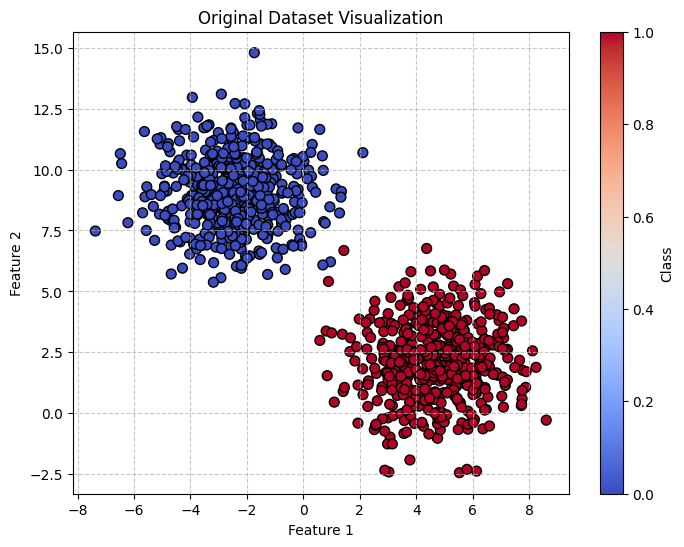

In [ ]:
# Generate synthetic dataset with 2 classes and 2 dimensional feature space
X, y = make_blobs(n_samples=1000, centers=2, n_features=2,
                  cluster_std=1.5, random_state=42)

# Visualize the original dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='o', s=50)
plt.title('Original Dataset Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Split the data (70% train, 10% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)  # 0.125*0.8=0.1

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

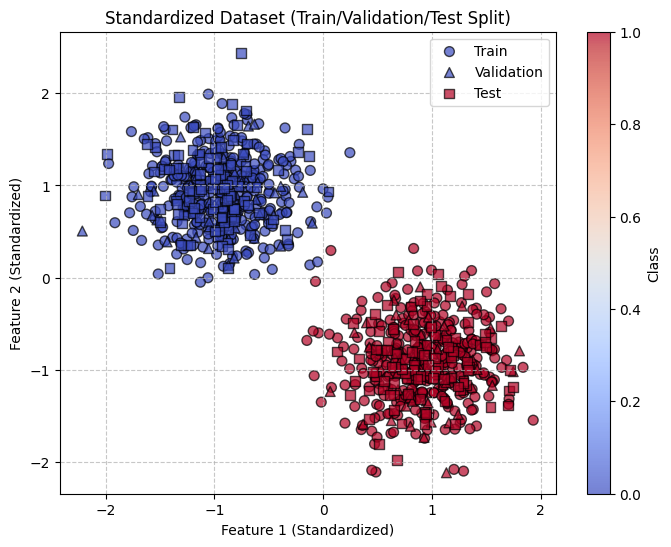

In [ ]:
# Visualize the standardized dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='o', s=50, label='Train', alpha=0.7)
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='^', s=50, label='Validation', alpha=0.7) # Added validation set
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='s', s=50, label='Test', alpha=0.7)
plt.title('Standardized Dataset (Train/Validation/Test Split)') # Updated title
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.colorbar(label='Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Convert to PyTorch tensors and move to device
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device) # Added validation tensor
y_val_tensor = torch.LongTensor(y_val).to(device)   # Added validation tensor
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

In [3]:
# Define the linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

In [4]:
# Training function
def train_model(loss_function, learning_rate=0.01, epochs=1000):
    # Initialize model and move to device
    model = LinearClassifier(input_dim=2, output_dim=2).to(device)

    # Define optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Lists to store losses and accuracies
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []  # List to store validation accuracies


    # Training loop
    for epoch in range(epochs):
        # Forward pass
        model.train()  # Set model to training mode
        outputs = model(X_train_tensor)

        # Compute loss
        if loss_function == 'mse':
            # For MSE, we need to convert labels to one-hot encoding
            y_one_hot = torch.zeros(y_train_tensor.size(0), 2).to(device)
            y_one_hot.scatter_(1, y_train_tensor.unsqueeze(1), 1)
            loss = nn.MSELoss()(outputs, y_one_hot)
        else:
            loss = nn.CrossEntropyLoss()(outputs, y_train_tensor)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)

        # Evaluate on validation set
        model.eval() # Set model to evaluation mode
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            if loss_function == 'mse':
                 # For MSE, we need to convert labels to one-hot encoding
                y_val_one_hot = torch.zeros(y_val_tensor.size(0), 2).to(device)
                y_val_one_hot.scatter_(1, y_val_tensor.unsqueeze(1), 1)
                val_loss = nn.MSELoss()(val_outputs, y_val_one_hot)
            else:
                val_loss = nn.CrossEntropyLoss()(val_outputs, y_val_tensor)
            _, val_predicted = torch.max(val_outputs.data, 1) # Calculate validation accuracy
            val_accuracy = (val_predicted == y_val_tensor).sum().item() / y_val_tensor.size(0) # Calculate validation accuracy


        # Store metrics
        losses.append(loss.item())
        accuracies.append(accuracy)
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)


        # Print every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train Accuracy: {accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}') # Added validation accuracy

    return model, losses, accuracies, val_losses, val_accuracies # Returned validation losses and accuracies

In [ ]:
# Train with CE loss functions
print("Training with Cross-Entropy Loss:")
ce_model, ce_losses, ce_accuracies, ce_val_losses, ce_val_accuracies = train_model('ce')

Training with Cross-Entropy Loss:
Epoch [10/1000], Train Loss: 0.6427, Train Accuracy: 0.5043, Val Loss: 0.6316, Val Accuracy: 0.5100
Epoch [20/1000], Train Loss: 0.5747, Train Accuracy: 0.6257, Val Loss: 0.5632, Val Accuracy: 0.7100
Epoch [30/1000], Train Loss: 0.5176, Train Accuracy: 0.8200, Val Loss: 0.5059, Val Accuracy: 0.8700
Epoch [40/1000], Train Loss: 0.4693, Train Accuracy: 0.9186, Val Loss: 0.4575, Val Accuracy: 0.9200
Epoch [50/1000], Train Loss: 0.4283, Train Accuracy: 0.9614, Val Loss: 0.4165, Val Accuracy: 0.9800
Epoch [60/1000], Train Loss: 0.3933, Train Accuracy: 0.9757, Val Loss: 0.3816, Val Accuracy: 0.9800
Epoch [70/1000], Train Loss: 0.3632, Train Accuracy: 0.9871, Val Loss: 0.3517, Val Accuracy: 1.0000
Epoch [80/1000], Train Loss: 0.3371, Train Accuracy: 0.9900, Val Loss: 0.3258, Val Accuracy: 1.0000
Epoch [90/1000], Train Loss: 0.3144, Train Accuracy: 0.9957, Val Loss: 0.3033, Val Accuracy: 1.0000
Epoch [100/1000], Train Loss: 0.2945, Train Accuracy: 0.9957, Val 

In [ ]:
# Train with MSE loss functions
print("\nTraining with MSE Loss:")
mse_model, mse_losses, mse_accuracies, mse_val_losses, mse_val_accuracies = train_model('mse')


Training with MSE Loss:
Epoch [10/1000], Train Loss: 0.4659, Train Accuracy: 0.5057, Val Loss: 0.4689, Val Accuracy: 0.5000
Epoch [20/1000], Train Loss: 0.3624, Train Accuracy: 0.5629, Val Loss: 0.3657, Val Accuracy: 0.5300
Epoch [30/1000], Train Loss: 0.2851, Train Accuracy: 0.7200, Val Loss: 0.2884, Val Accuracy: 0.6700
Epoch [40/1000], Train Loss: 0.2269, Train Accuracy: 0.8286, Val Loss: 0.2301, Val Accuracy: 0.8100
Epoch [50/1000], Train Loss: 0.1827, Train Accuracy: 0.9071, Val Loss: 0.1858, Val Accuracy: 0.9000
Epoch [60/1000], Train Loss: 0.1489, Train Accuracy: 0.9500, Val Loss: 0.1518, Val Accuracy: 0.9500
Epoch [70/1000], Train Loss: 0.1229, Train Accuracy: 0.9686, Val Loss: 0.1256, Val Accuracy: 0.9600
Epoch [80/1000], Train Loss: 0.1027, Train Accuracy: 0.9786, Val Loss: 0.1052, Val Accuracy: 0.9700
Epoch [90/1000], Train Loss: 0.0870, Train Accuracy: 0.9900, Val Loss: 0.0892, Val Accuracy: 0.9900
Epoch [100/1000], Train Loss: 0.0746, Train Accuracy: 0.9943, Val Loss: 0.0

In [ ]:
# Move models to CPU for plotting if they were on GPU
if torch.cuda.is_available():
    ce_model = ce_model.cpu()
    mse_model = mse_model.cpu()

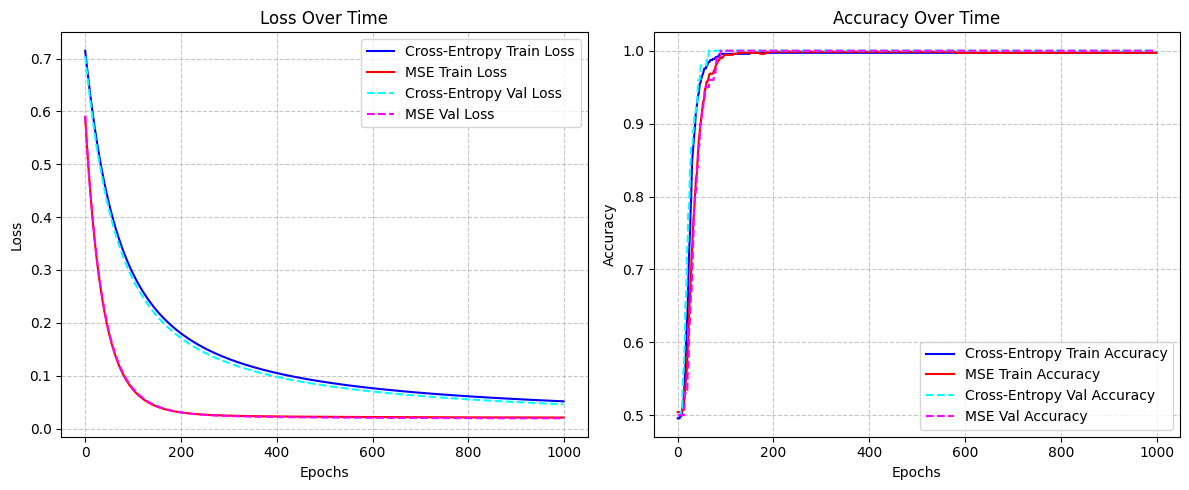

In [ ]:
# Plotting training results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ce_losses, label='Cross-Entropy Train Loss', color='blue')
plt.plot(mse_losses, label='MSE Train Loss', color='red')
plt.plot(ce_val_losses, label='Cross-Entropy Val Loss', color='cyan', linestyle='--') # Added CE validation loss
plt.plot(mse_val_losses, label='MSE Val Loss', color='magenta', linestyle='--') # Added MSE validation loss
plt.title('Loss Over Time') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(ce_accuracies, label='Cross-Entropy Train Accuracy', color='blue')
plt.plot(mse_accuracies, label='MSE Train Accuracy', color='red')
plt.plot(ce_val_accuracies, label='Cross-Entropy Val Accuracy', color='cyan', linestyle='--') # Added CE validation accuracy
plt.plot(mse_val_accuracies, label='MSE Val Accuracy', color='magenta', linestyle='--') # Added MSE validation accuracy
plt.title('Accuracy Over Time') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test set
def evaluate_model(model):
    model.eval()
    # Move model to device
    model = model.to(device)
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    return accuracy

ce_test_accuracy = evaluate_model(ce_model)
mse_test_accuracy = evaluate_model(mse_model)

print(f"\nTest Accuracy - Cross-Entropy: {ce_test_accuracy:.4f}")
print(f"Test Accuracy - MSE: {mse_test_accuracy:.4f}")


Test Accuracy - Cross-Entropy: 1.0000
Test Accuracy - MSE: 1.0000


/tmp/ipython-input-4131605936.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
/tmp/ipython-input-4131605936.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, h))


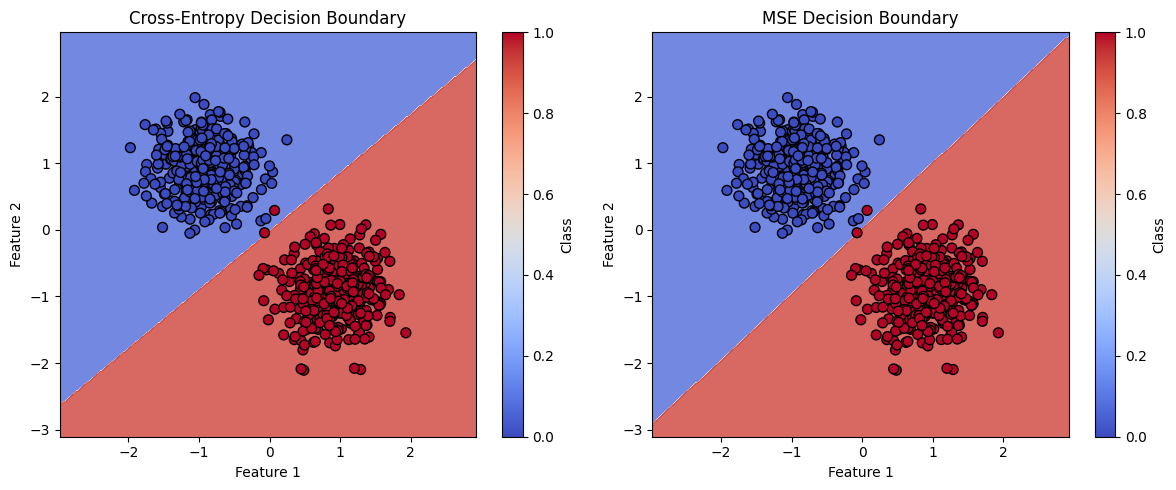

In [ ]:
# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in the mesh

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    _, Z = torch.max(Z.data, 1)
    Z = Z.numpy().reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,
                edgecolors='k', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Class')

# Plot decision boundaries
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_decision_boundary(ce_model, X_train, y_train, "Cross-Entropy Decision Boundary")

plt.subplot(1, 2, 2)
plot_decision_boundary(mse_model, X_train, y_train, "MSE Decision Boundary")

plt.tight_layout()
plt.show()

/tmp/ipython-input-1703246827.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
/tmp/ipython-input-1703246827.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np.arange(y_min, y_max, h))


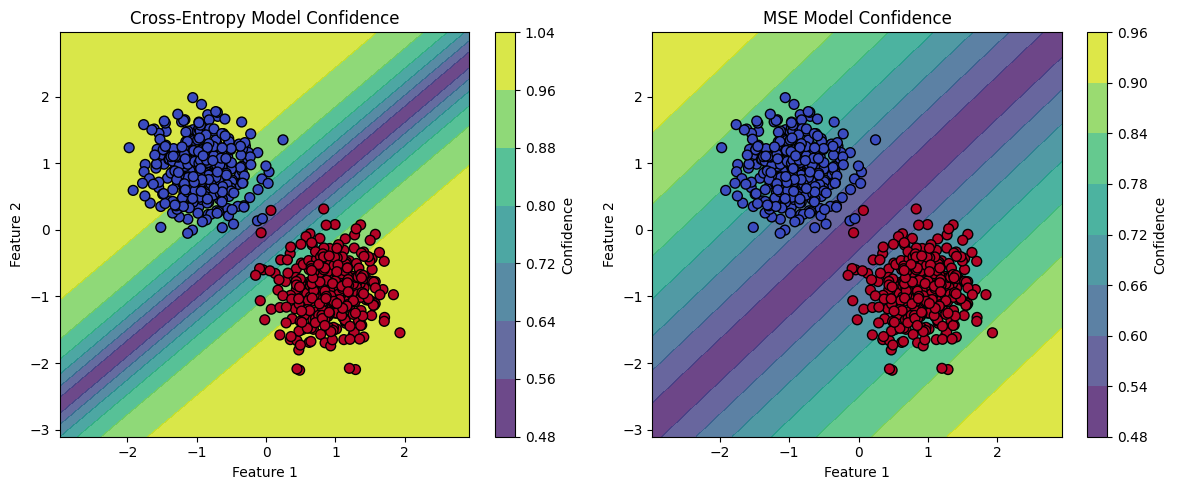

In [ ]:
# Additional visualization: Model confidence
def plot_model_confidence(model, X, y, title):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in the mesh

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    # Apply softmax to get probabilities
    softmax = nn.Softmax(dim=1)
    Z_probs = softmax(Z)
    # Get the confidence (max probability)
    confidence, _ = torch.max(Z_probs.data, 1)
    confidence = confidence.numpy().reshape(xx.shape)

    # Plot the confidence
    plt.contourf(xx, yy, confidence, cmap=plt.cm.viridis, alpha=0.8)
    plt.colorbar(label='Confidence')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,
                edgecolors='k', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

# Plot model confidence
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_model_confidence(ce_model, X_train, y_train, "Cross-Entropy Model Confidence")

plt.subplot(1, 2, 2)
plot_model_confidence(mse_model, X_train, y_train, "MSE Model Confidence")

plt.tight_layout()
plt.show()

<Figure size 1200x500 with 0 Axes>

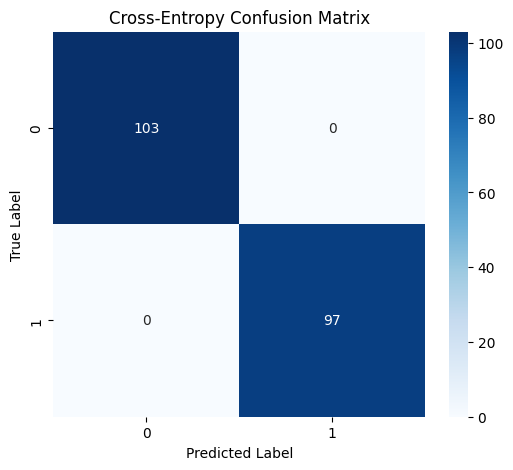

<Figure size 1200x500 with 0 Axes>

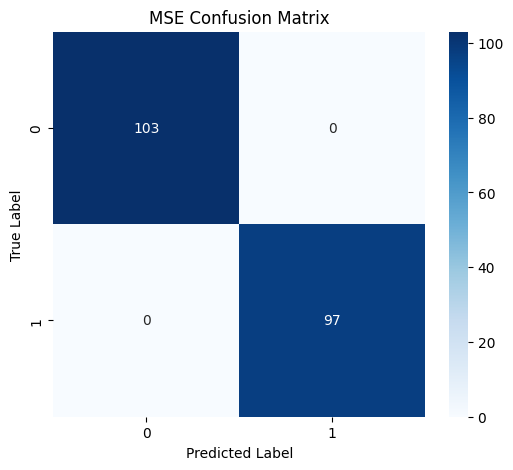

In [ ]:
# Confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X, y, title):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.FloatTensor(X))
        _, predicted = torch.max(outputs.data, 1)

    cm = confusion_matrix(y, predicted.numpy())
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Plot confusion matrices
plt.figure(figsize=(12, 5))
plot_confusion_matrix(ce_model, X_test, y_test, "Cross-Entropy Confusion Matrix")
plt.show()

plt.figure(figsize=(12, 5))
plot_confusion_matrix(mse_model, X_test, y_test, "MSE Confusion Matrix")
plt.show()

# Q1) Increase Std to 3.0 in "make_blob" function and report all the plots and measures  [2 Marks]

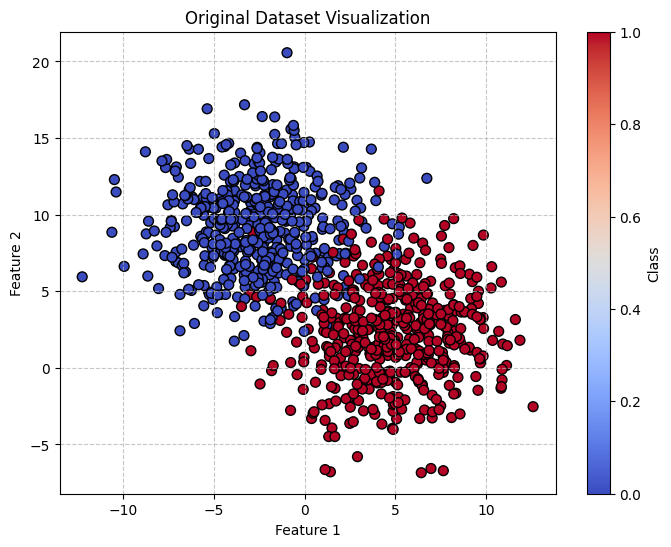

In [3]:
# Generate synthetic dataset with 2 classes and 2 dimensional feature space
X, y = make_blobs(n_samples=1000, centers=2, n_features=2,
                  cluster_std=3.0, random_state=42)

# Visualize the original dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='o', s=50)
plt.title('Original Dataset Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [4]:
# Split the data (70% train, 10% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)  # 0.125*0.8=0.1

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

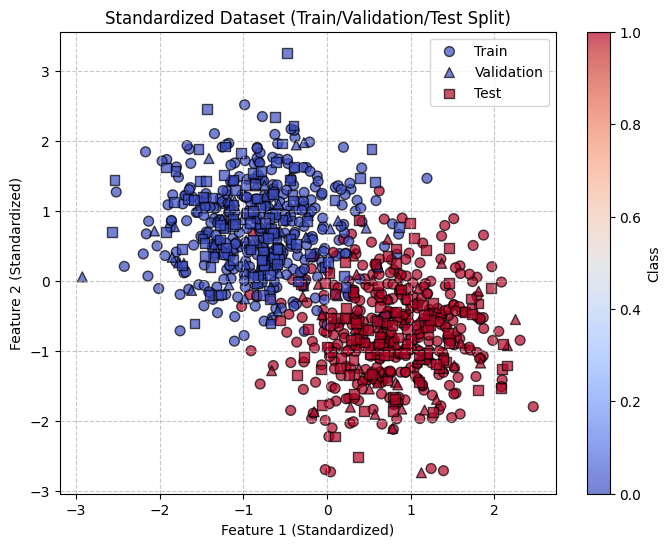

In [5]:
# Visualize the standardized dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='o', s=50, label='Train', alpha=0.7)
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='^', s=50, label='Validation', alpha=0.7) # Added validation set
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='s', s=50, label='Test', alpha=0.7)
plt.title('Standardized Dataset (Train/Validation/Test Split)') # Updated title
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.colorbar(label='Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [6]:
# Convert to PyTorch tensors and move to device
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device) # Added validation tensor
y_val_tensor = torch.LongTensor(y_val).to(device)   # Added validation tensor
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

In [10]:
# Train with CE loss functions
print("Training with Cross-Entropy Loss:")
ce_model, ce_losses, ce_accuracies, ce_val_losses, ce_val_accuracies = train_model('ce')

Training with Cross-Entropy Loss:
Epoch [10/1000], Train Loss: 0.9723, Train Accuracy: 0.1757, Val Loss: 0.9826, Val Accuracy: 0.1600
Epoch [20/1000], Train Loss: 0.8817, Train Accuracy: 0.2457, Val Loss: 0.8899, Val Accuracy: 0.2800
Epoch [30/1000], Train Loss: 0.8030, Train Accuracy: 0.3371, Val Loss: 0.8096, Val Accuracy: 0.3800
Epoch [40/1000], Train Loss: 0.7352, Train Accuracy: 0.4371, Val Loss: 0.7402, Val Accuracy: 0.4400
Epoch [50/1000], Train Loss: 0.6769, Train Accuracy: 0.5657, Val Loss: 0.6805, Val Accuracy: 0.5700
Epoch [60/1000], Train Loss: 0.6269, Train Accuracy: 0.6686, Val Loss: 0.6292, Val Accuracy: 0.6500
Epoch [70/1000], Train Loss: 0.5838, Train Accuracy: 0.7529, Val Loss: 0.5849, Val Accuracy: 0.7000
Epoch [80/1000], Train Loss: 0.5466, Train Accuracy: 0.8100, Val Loss: 0.5465, Val Accuracy: 0.7800
Epoch [90/1000], Train Loss: 0.5144, Train Accuracy: 0.8514, Val Loss: 0.5132, Val Accuracy: 0.8300
Epoch [100/1000], Train Loss: 0.4863, Train Accuracy: 0.8786, Val 

In [11]:
# Train with MSE loss functions
print("\nTraining with MSE Loss:")
mse_model, mse_losses, mse_accuracies, mse_val_losses, mse_val_accuracies = train_model('mse')


Training with MSE Loss:
Epoch [10/1000], Train Loss: 0.2839, Train Accuracy: 0.9357, Val Loss: 0.2509, Val Accuracy: 0.9400
Epoch [20/1000], Train Loss: 0.2307, Train Accuracy: 0.9400, Val Loss: 0.2019, Val Accuracy: 0.9400
Epoch [30/1000], Train Loss: 0.1909, Train Accuracy: 0.9414, Val Loss: 0.1655, Val Accuracy: 0.9400
Epoch [40/1000], Train Loss: 0.1610, Train Accuracy: 0.9429, Val Loss: 0.1385, Val Accuracy: 0.9400
Epoch [50/1000], Train Loss: 0.1386, Train Accuracy: 0.9429, Val Loss: 0.1184, Val Accuracy: 0.9300
Epoch [60/1000], Train Loss: 0.1217, Train Accuracy: 0.9429, Val Loss: 0.1035, Val Accuracy: 0.9400
Epoch [70/1000], Train Loss: 0.1090, Train Accuracy: 0.9400, Val Loss: 0.0923, Val Accuracy: 0.9400
Epoch [80/1000], Train Loss: 0.0993, Train Accuracy: 0.9429, Val Loss: 0.0840, Val Accuracy: 0.9400
Epoch [90/1000], Train Loss: 0.0919, Train Accuracy: 0.9443, Val Loss: 0.0777, Val Accuracy: 0.9300
Epoch [100/1000], Train Loss: 0.0863, Train Accuracy: 0.9443, Val Loss: 0.0

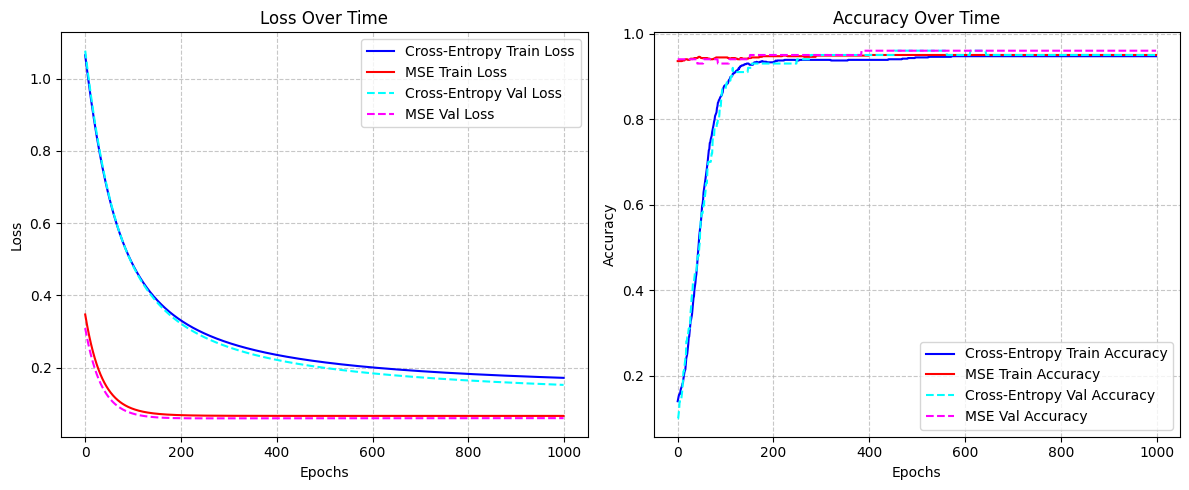

In [12]:
# Plotting training results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ce_losses, label='Cross-Entropy Train Loss', color='blue')
plt.plot(mse_losses, label='MSE Train Loss', color='red')
plt.plot(ce_val_losses, label='Cross-Entropy Val Loss', color='cyan', linestyle='--') # Added CE validation loss
plt.plot(mse_val_losses, label='MSE Val Loss', color='magenta', linestyle='--') # Added MSE validation loss
plt.title('Loss Over Time') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(ce_accuracies, label='Cross-Entropy Train Accuracy', color='blue')
plt.plot(mse_accuracies, label='MSE Train Accuracy', color='red')
plt.plot(ce_val_accuracies, label='Cross-Entropy Val Accuracy', color='cyan', linestyle='--') # Added CE validation accuracy
plt.plot(mse_val_accuracies, label='MSE Val Accuracy', color='magenta', linestyle='--') # Added MSE validation accuracy
plt.title('Accuracy Over Time') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [13]:
# Evaluate on test set
def evaluate_model(model):
    model.eval()
    # Move model to device
    model = model.to(device)
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    return accuracy

ce_test_accuracy = evaluate_model(ce_model)
mse_test_accuracy = evaluate_model(mse_model)

print(f"\nTest Accuracy - Cross-Entropy: {ce_test_accuracy:.4f}")
print(f"Test Accuracy - MSE: {mse_test_accuracy:.4f}")


Test Accuracy - Cross-Entropy: 0.9650
Test Accuracy - MSE: 0.9600


In [15]:
if torch.cuda.is_available():
    ce_model = ce_model.cpu()
    mse_model = mse_model.cpu()

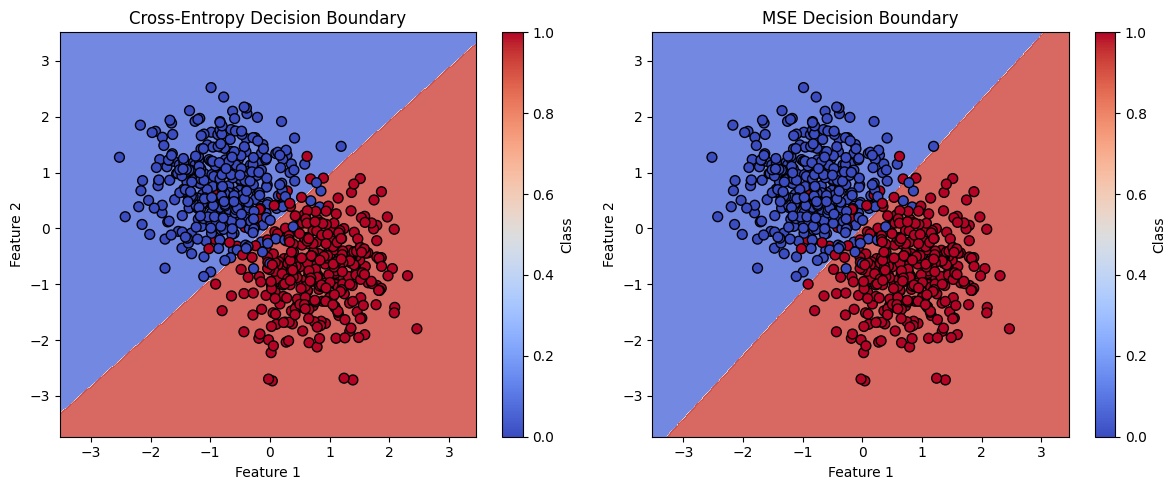

In [16]:
# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in the mesh

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    _, Z = torch.max(Z.data, 1)
    Z = Z.numpy().reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,
                edgecolors='k', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Class')

# Plot decision boundaries
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_decision_boundary(ce_model, X_train, y_train, "Cross-Entropy Decision Boundary")

plt.subplot(1, 2, 2)
plot_decision_boundary(mse_model, X_train, y_train, "MSE Decision Boundary")

plt.tight_layout()
plt.show()

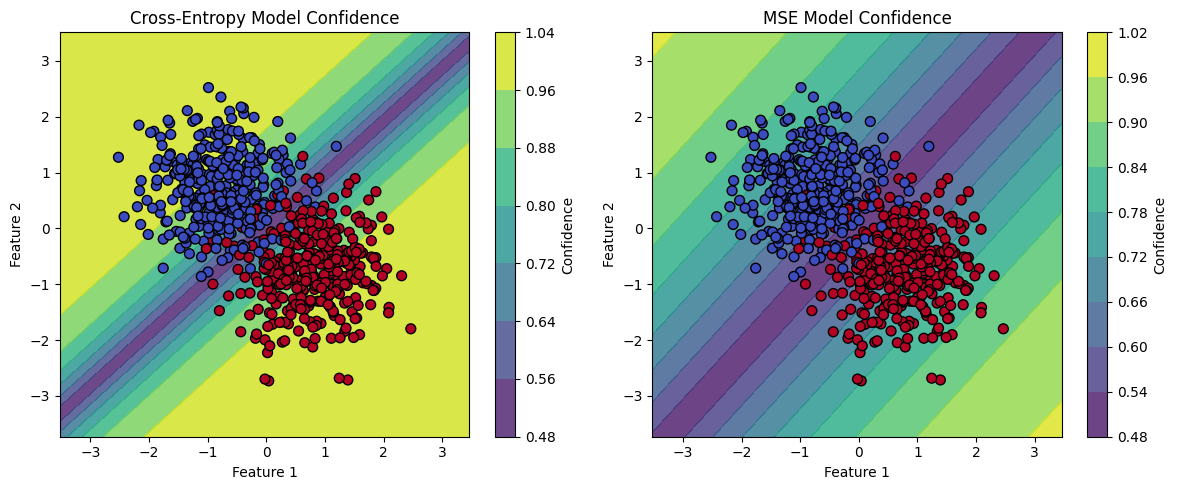

In [17]:
# Additional visualization: Model confidence
def plot_model_confidence(model, X, y, title):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in the mesh

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    # Apply softmax to get probabilities
    softmax = nn.Softmax(dim=1)
    Z_probs = softmax(Z)
    # Get the confidence (max probability)
    confidence, _ = torch.max(Z_probs.data, 1)
    confidence = confidence.numpy().reshape(xx.shape)

    # Plot the confidence
    plt.contourf(xx, yy, confidence, cmap=plt.cm.viridis, alpha=0.8)
    plt.colorbar(label='Confidence')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,
                edgecolors='k', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

# Plot model confidence
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_model_confidence(ce_model, X_train, y_train, "Cross-Entropy Model Confidence")

plt.subplot(1, 2, 2)
plot_model_confidence(mse_model, X_train, y_train, "MSE Model Confidence")

plt.tight_layout()
plt.show()

<Figure size 1200x500 with 0 Axes>

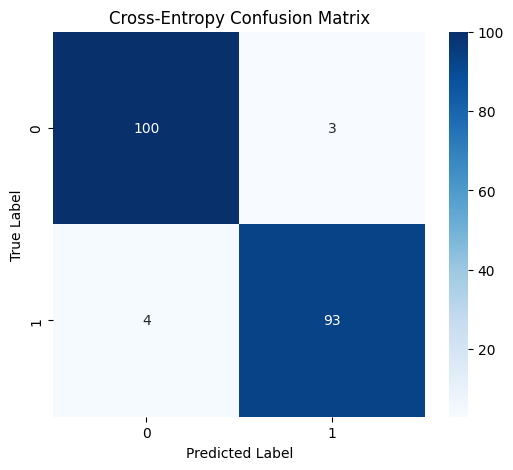

<Figure size 1200x500 with 0 Axes>

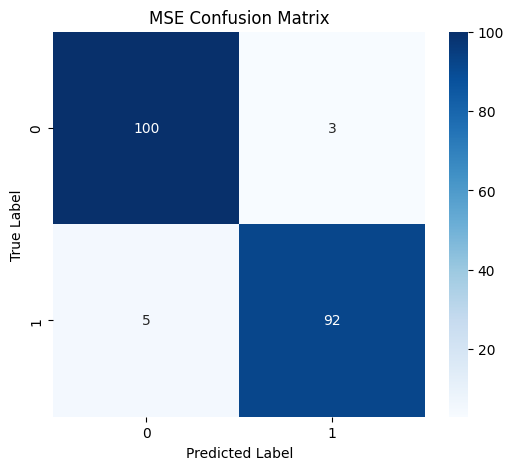

In [18]:
# Confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X, y, title):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.FloatTensor(X))
        _, predicted = torch.max(outputs.data, 1)

    cm = confusion_matrix(y, predicted.numpy())
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Plot confusion matrices
plt.figure(figsize=(12, 5))
plot_confusion_matrix(ce_model, X_test, y_test, "Cross-Entropy Confusion Matrix")
plt.show()

plt.figure(figsize=(12, 5))
plot_confusion_matrix(mse_model, X_test, y_test, "MSE Confusion Matrix")
plt.show()

#Q2) Increase n_cluster=5 and std=3.0 in "make_blob" function and report all the plots and measures [3 Marks]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
np.random.seed(42)

Using device: cuda


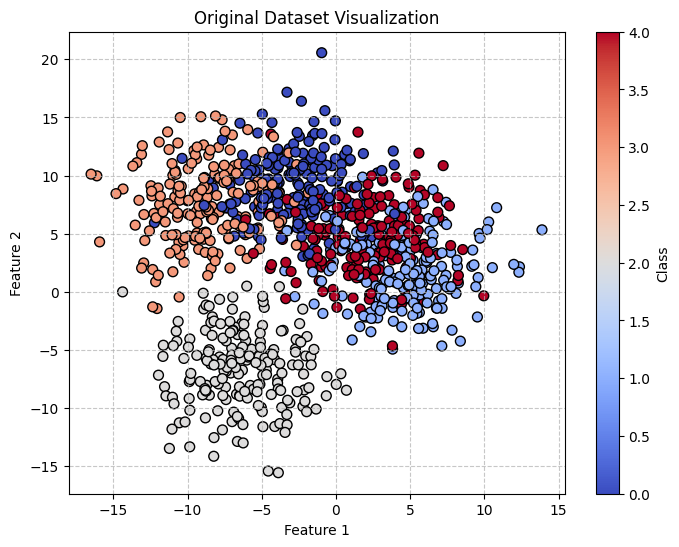

In [3]:
# Generate synthetic dataset with 2 classes and 2 dimensional feature space
X, y = make_blobs(n_samples=1000, centers=5, n_features=2,
                  cluster_std=3.0, random_state=42)

# Visualize the original dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='o', s=50)
plt.title('Original Dataset Visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Class')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [4]:
# Split the data (70% train, 10% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)  # 0.125*0.8=0.1

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

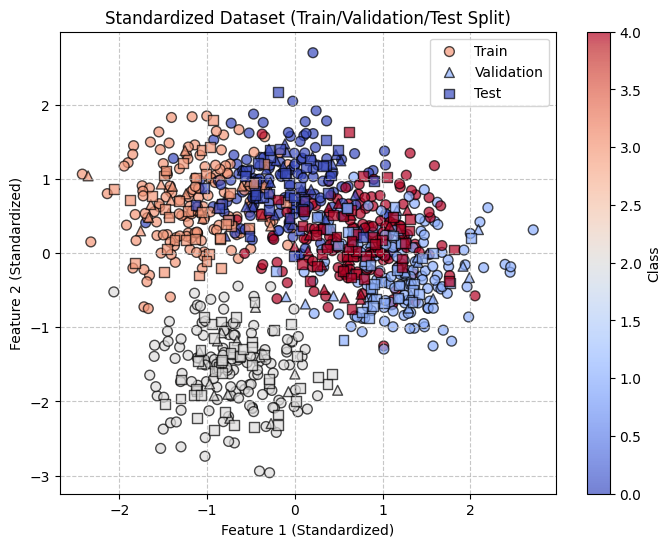

In [5]:
# Visualize the standardized dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='o', s=50, label='Train', alpha=0.7)
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='^', s=50, label='Validation', alpha=0.7) # Added validation set
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='s', s=50, label='Test', alpha=0.7)
plt.title('Standardized Dataset (Train/Validation/Test Split)') # Updated title
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.colorbar(label='Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [6]:
# Convert to PyTorch tensors and move to device
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device) # Added validation tensor
y_val_tensor = torch.LongTensor(y_val).to(device)   # Added validation tensor
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

In [7]:
# Define the linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

In [8]:
# Training function
def train_model(loss_function, learning_rate=0.01, epochs=1000, output_dim=2):
    # Initialize model and move to device
    model = LinearClassifier(input_dim=2, output_dim=output_dim).to(device)

    # Define optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Lists to store losses and accuracies
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []  # List to store validation accuracies


    # Training loop
    for epoch in range(epochs):
        # Forward pass
        model.train()  # Set model to training mode
        outputs = model(X_train_tensor)

        # Compute loss
        if loss_function == 'mse':
            # For MSE, we need to convert labels to one-hot encoding
            y_one_hot = torch.zeros(y_train_tensor.size(0), output_dim).to(device)
            y_one_hot.scatter_(1, y_train_tensor.unsqueeze(1), 1)
            loss = nn.MSELoss()(outputs, y_one_hot)
        else:
            loss = nn.CrossEntropyLoss()(outputs, y_train_tensor)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)

        # Evaluate on validation set
        model.eval() # Set model to evaluation mode
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            if loss_function == 'mse':
                 # For MSE, we need to convert labels to one-hot encoding
                y_val_one_hot = torch.zeros(y_val_tensor.size(0), output_dim).to(device)
                y_val_one_hot.scatter_(1, y_val_tensor.unsqueeze(1), 1)
                val_loss = nn.MSELoss()(val_outputs, y_val_one_hot)
            else:
                val_loss = nn.CrossEntropyLoss()(val_outputs, y_val_tensor)
            _, val_predicted = torch.max(val_outputs.data, 1) # Calculate validation accuracy
            val_accuracy = (val_predicted == y_val_tensor).sum().item() / y_val_tensor.size(0) # Calculate validation accuracy


        # Store metrics
        losses.append(loss.item())
        accuracies.append(accuracy)
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)


        # Print every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train Accuracy: {accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}') # Added validation accuracy

    return model, losses, accuracies, val_losses, val_accuracies # Returned validation losses and accuracies

In [9]:
# Train with CE loss functions
print("Training with Cross-Entropy Loss:")
ce_model, ce_losses, ce_accuracies, ce_val_losses, ce_val_accuracies = train_model('ce', output_dim=5)

Training with Cross-Entropy Loss:
Epoch [10/1000], Train Loss: 1.5533, Train Accuracy: 0.3214, Val Loss: 1.5266, Val Accuracy: 0.4200
Epoch [20/1000], Train Loss: 1.5255, Train Accuracy: 0.3743, Val Loss: 1.5023, Val Accuracy: 0.4500
Epoch [30/1000], Train Loss: 1.4988, Train Accuracy: 0.4143, Val Loss: 1.4789, Val Accuracy: 0.4800
Epoch [40/1000], Train Loss: 1.4732, Train Accuracy: 0.4286, Val Loss: 1.4565, Val Accuracy: 0.4900
Epoch [50/1000], Train Loss: 1.4487, Train Accuracy: 0.4486, Val Loss: 1.4349, Val Accuracy: 0.4900
Epoch [60/1000], Train Loss: 1.4252, Train Accuracy: 0.4686, Val Loss: 1.4142, Val Accuracy: 0.5000
Epoch [70/1000], Train Loss: 1.4027, Train Accuracy: 0.4914, Val Loss: 1.3942, Val Accuracy: 0.5200
Epoch [80/1000], Train Loss: 1.3810, Train Accuracy: 0.5057, Val Loss: 1.3751, Val Accuracy: 0.5200
Epoch [90/1000], Train Loss: 1.3603, Train Accuracy: 0.5129, Val Loss: 1.3567, Val Accuracy: 0.5300
Epoch [100/1000], Train Loss: 1.3404, Train Accuracy: 0.5186, Val 

In [10]:
# Train with MSE loss functions
print("\nTraining with MSE Loss:")
mse_model, mse_losses, mse_accuracies, mse_val_losses, mse_val_accuracies = train_model('mse', output_dim=5)


Training with MSE Loss:
Epoch [10/1000], Train Loss: 0.5905, Train Accuracy: 0.2571, Val Loss: 0.5664, Val Accuracy: 0.2300
Epoch [20/1000], Train Loss: 0.5529, Train Accuracy: 0.2686, Val Loss: 0.5303, Val Accuracy: 0.2400
Epoch [30/1000], Train Loss: 0.5181, Train Accuracy: 0.2800, Val Loss: 0.4971, Val Accuracy: 0.2600
Epoch [40/1000], Train Loss: 0.4860, Train Accuracy: 0.3014, Val Loss: 0.4664, Val Accuracy: 0.3000
Epoch [50/1000], Train Loss: 0.4564, Train Accuracy: 0.3200, Val Loss: 0.4381, Val Accuracy: 0.3000
Epoch [60/1000], Train Loss: 0.4291, Train Accuracy: 0.3343, Val Loss: 0.4120, Val Accuracy: 0.3000
Epoch [70/1000], Train Loss: 0.4038, Train Accuracy: 0.3486, Val Loss: 0.3879, Val Accuracy: 0.3300
Epoch [80/1000], Train Loss: 0.3805, Train Accuracy: 0.3529, Val Loss: 0.3656, Val Accuracy: 0.3500
Epoch [90/1000], Train Loss: 0.3590, Train Accuracy: 0.3571, Val Loss: 0.3451, Val Accuracy: 0.3600
Epoch [100/1000], Train Loss: 0.3391, Train Accuracy: 0.3729, Val Loss: 0.3

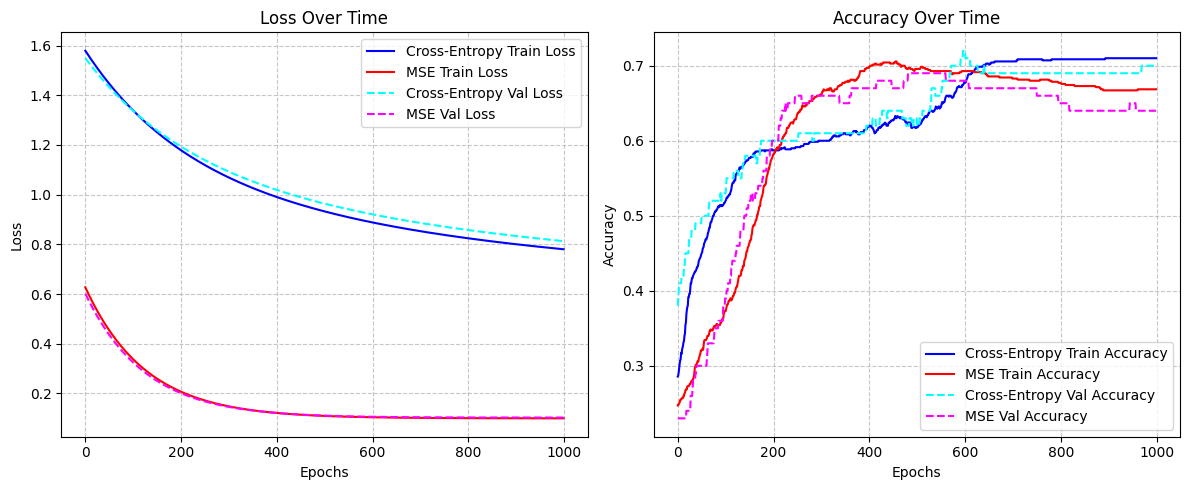

In [11]:
# Plotting training results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ce_losses, label='Cross-Entropy Train Loss', color='blue')
plt.plot(mse_losses, label='MSE Train Loss', color='red')
plt.plot(ce_val_losses, label='Cross-Entropy Val Loss', color='cyan', linestyle='--') # Added CE validation loss
plt.plot(mse_val_losses, label='MSE Val Loss', color='magenta', linestyle='--') # Added MSE validation loss
plt.title('Loss Over Time') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(ce_accuracies, label='Cross-Entropy Train Accuracy', color='blue')
plt.plot(mse_accuracies, label='MSE Train Accuracy', color='red')
plt.plot(ce_val_accuracies, label='Cross-Entropy Val Accuracy', color='cyan', linestyle='--') # Added CE validation accuracy
plt.plot(mse_val_accuracies, label='MSE Val Accuracy', color='magenta', linestyle='--') # Added MSE validation accuracy
plt.title('Accuracy Over Time') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [12]:
# Evaluate on test set
def evaluate_model(model):
    model.eval()
    # Move model to device
    model = model.to(device)
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    return accuracy

ce_test_accuracy = evaluate_model(ce_model)
mse_test_accuracy = evaluate_model(mse_model)

print(f"\nTest Accuracy - Cross-Entropy: {ce_test_accuracy:.4f}")
print(f"Test Accuracy - MSE: {mse_test_accuracy:.4f}")


Test Accuracy - Cross-Entropy: 0.6950
Test Accuracy - MSE: 0.6500


In [13]:
if torch.cuda.is_available():
    ce_model = ce_model.cpu()
    mse_model = mse_model.cpu()

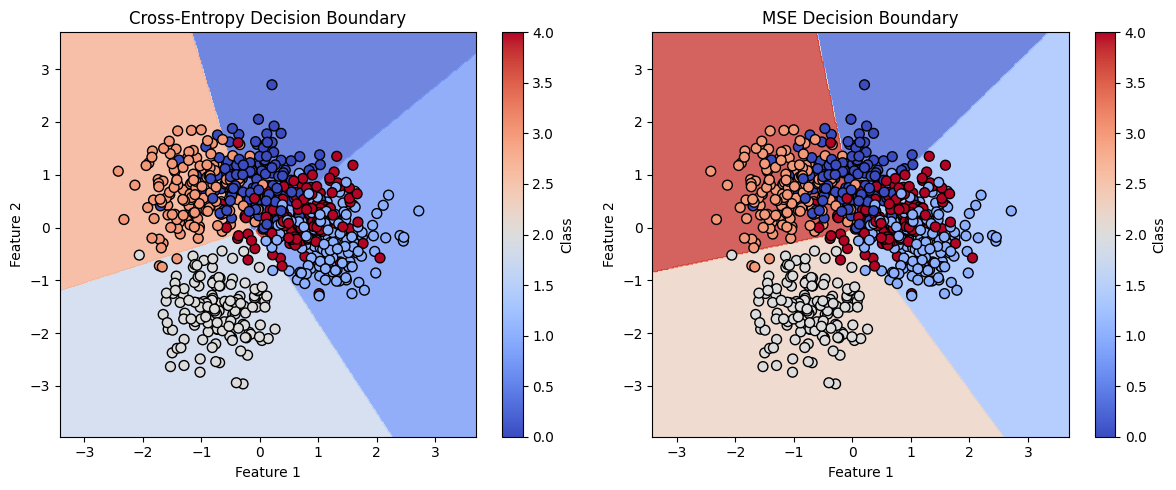

In [14]:
# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in the mesh

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    _, Z = torch.max(Z.data, 1)
    Z = Z.numpy().reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,
                edgecolors='k', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Class')

# Plot decision boundaries
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_decision_boundary(ce_model, X_train, y_train, "Cross-Entropy Decision Boundary")

plt.subplot(1, 2, 2)
plot_decision_boundary(mse_model, X_train, y_train, "MSE Decision Boundary")

plt.tight_layout()
plt.show()

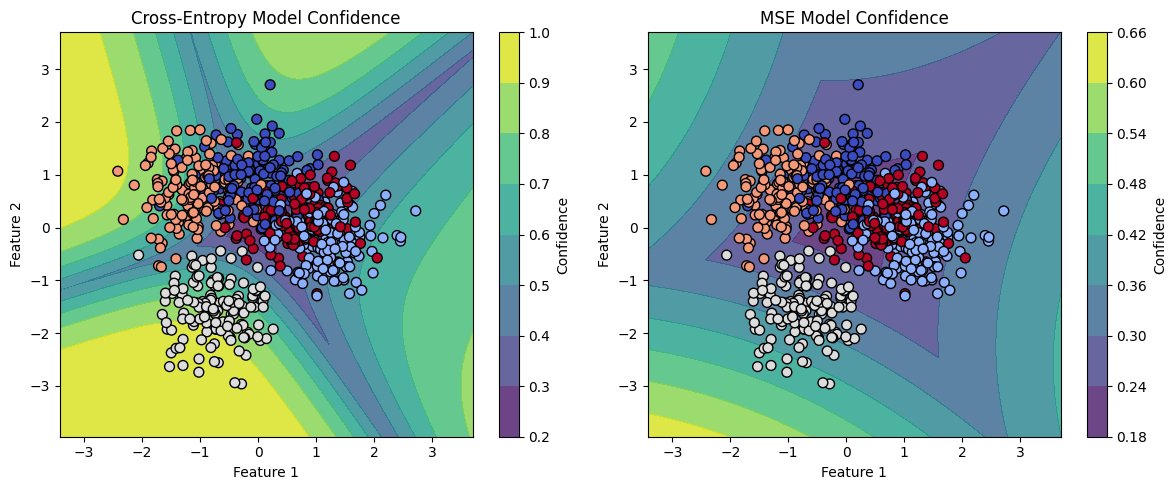

In [15]:
# Additional visualization: Model confidence
def plot_model_confidence(model, X, y, title):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # step size in the mesh

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]))
    # Apply softmax to get probabilities
    softmax = nn.Softmax(dim=1)
    Z_probs = softmax(Z)
    # Get the confidence (max probability)
    confidence, _ = torch.max(Z_probs.data, 1)
    confidence = confidence.numpy().reshape(xx.shape)

    # Plot the confidence
    plt.contourf(xx, yy, confidence, cmap=plt.cm.viridis, alpha=0.8)
    plt.colorbar(label='Confidence')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,
                edgecolors='k', s=50)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

# Plot model confidence
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_model_confidence(ce_model, X_train, y_train, "Cross-Entropy Model Confidence")

plt.subplot(1, 2, 2)
plot_model_confidence(mse_model, X_train, y_train, "MSE Model Confidence")

plt.tight_layout()
plt.show()

<Figure size 1200x500 with 0 Axes>

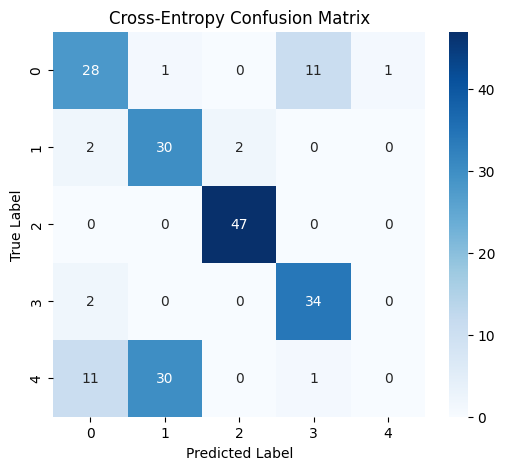

<Figure size 1200x500 with 0 Axes>

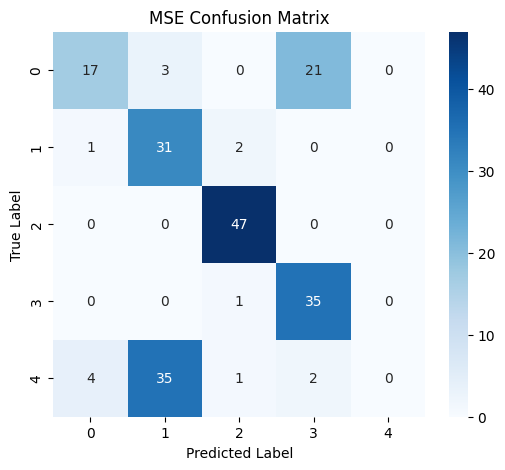

In [16]:
# Confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X, y, title):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.FloatTensor(X))
        _, predicted = torch.max(outputs.data, 1)

    cm = confusion_matrix(y, predicted.numpy())
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Plot confusion matrices
plt.figure(figsize=(12, 5))
plot_confusion_matrix(ce_model, X_test, y_test, "Cross-Entropy Confusion Matrix")
plt.show()

plt.figure(figsize=(12, 5))
plot_confusion_matrix(mse_model, X_test, y_test, "MSE Confusion Matrix")
plt.show()

#Q3) Perform similar experiment with 20 dimensional features(using make_blob) with 5 clusters and std=3.0 and report all measures (train-val-test accuracies, accuracy curves, confusion matrix) for both CE and MSE loss [5 Marks]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
np.random.seed(42)

Using device: cuda


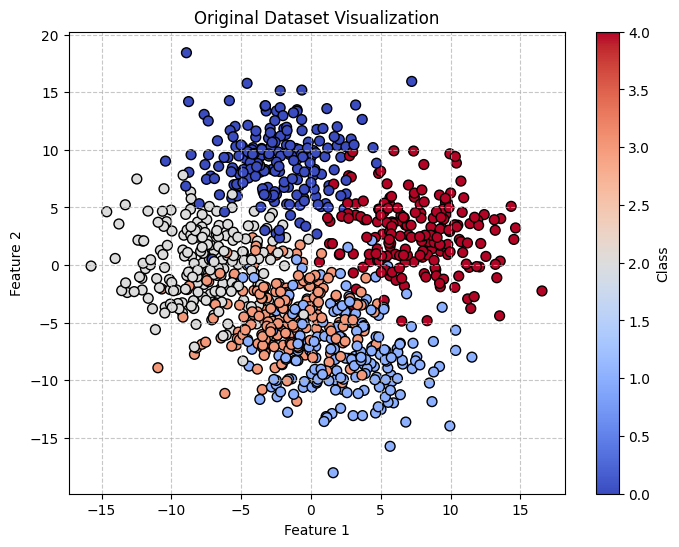

In [4]:
X, y = make_blobs(n_samples=1000, centers=5, n_features=20,
                  cluster_std=3.0, random_state=42)

# Visualize the original dataset
# plt.figure(figsize=(8, 6))
# plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm,
#             edgecolors='k', marker='o', s=50)
# plt.title('Original Dataset Visualization')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.colorbar(label='Class')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

In [5]:
# Split the data (70% train, 10% validation, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)  # 0.125*0.8=0.1

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

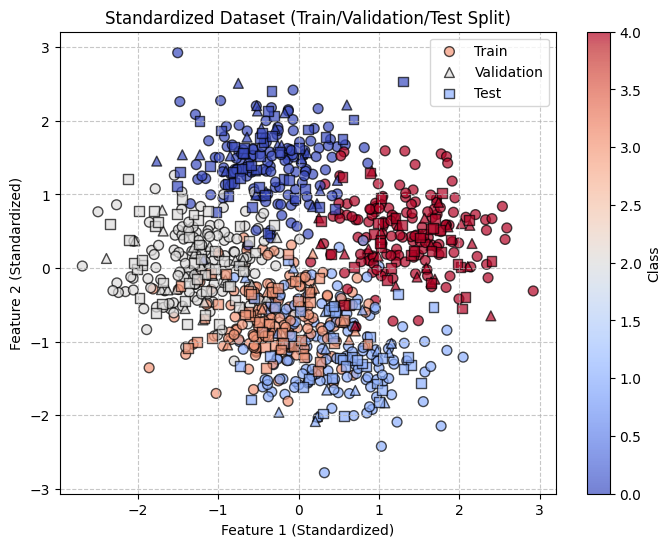

In [6]:
# Visualize the standardized dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='o', s=50, label='Train', alpha=0.7)
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='^', s=50, label='Validation', alpha=0.7) # Added validation set
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm,
            edgecolors='k', marker='s', s=50, label='Test', alpha=0.7)
plt.title('Standardized Dataset (Train/Validation/Test Split)') # Updated title
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.colorbar(label='Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [7]:
# Convert to PyTorch tensors and move to device
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device) # Added validation tensor
y_val_tensor = torch.LongTensor(y_val).to(device)   # Added validation tensor
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

In [8]:
# Define the linear classifier model
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

In [9]:
# Training function
def train_model(loss_function, learning_rate=0.01, epochs=1000, output_dim=2, input_dim=2):
    # Initialize model and move to device
    model = LinearClassifier(input_dim=input_dim, output_dim=output_dim).to(device)

    # Define optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Lists to store losses and accuracies
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []  # List to store validation accuracies


    # Training loop
    for epoch in range(epochs):
        # Forward pass
        model.train()  # Set model to training mode
        outputs = model(X_train_tensor)

        # Compute loss
        if loss_function == 'mse':
            # For MSE, we need to convert labels to one-hot encoding
            y_one_hot = torch.zeros(y_train_tensor.size(0), output_dim).to(device)
            y_one_hot.scatter_(1, y_train_tensor.unsqueeze(1), 1)
            loss = nn.MSELoss()(outputs, y_one_hot)
        else:
            loss = nn.CrossEntropyLoss()(outputs, y_train_tensor)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)

        # Evaluate on validation set
        model.eval() # Set model to evaluation mode
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            if loss_function == 'mse':
                 # For MSE, we need to convert labels to one-hot encoding
                y_val_one_hot = torch.zeros(y_val_tensor.size(0), output_dim).to(device)
                y_val_one_hot.scatter_(1, y_val_tensor.unsqueeze(1), 1)
                val_loss = nn.MSELoss()(val_outputs, y_val_one_hot)
            else:
                val_loss = nn.CrossEntropyLoss()(val_outputs, y_val_tensor)
            _, val_predicted = torch.max(val_outputs.data, 1) # Calculate validation accuracy
            val_accuracy = (val_predicted == y_val_tensor).sum().item() / y_val_tensor.size(0) # Calculate validation accuracy


        # Store metrics
        losses.append(loss.item())
        accuracies.append(accuracy)
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy)


        # Print every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train Accuracy: {accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}') # Added validation accuracy

    return model, losses, accuracies, val_losses, val_accuracies # Returned validation losses and accuracies

In [10]:
# Train with CE loss functions
print("Training with Cross-Entropy Loss:")
ce_model, ce_losses, ce_accuracies, ce_val_losses, ce_val_accuracies = train_model('ce', output_dim=5, input_dim=20)

Training with Cross-Entropy Loss:
Epoch [10/1000], Train Loss: 1.6493, Train Accuracy: 0.2714, Val Loss: 1.5978, Val Accuracy: 0.3100
Epoch [20/1000], Train Loss: 1.4029, Train Accuracy: 0.4186, Val Loss: 1.3567, Val Accuracy: 0.5000
Epoch [30/1000], Train Loss: 1.1970, Train Accuracy: 0.5657, Val Loss: 1.1569, Val Accuracy: 0.5600
Epoch [40/1000], Train Loss: 1.0265, Train Accuracy: 0.6871, Val Loss: 0.9923, Val Accuracy: 0.7200
Epoch [50/1000], Train Loss: 0.8859, Train Accuracy: 0.8100, Val Loss: 0.8574, Val Accuracy: 0.8000
Epoch [60/1000], Train Loss: 0.7704, Train Accuracy: 0.9086, Val Loss: 0.7468, Val Accuracy: 0.8400
Epoch [70/1000], Train Loss: 0.6754, Train Accuracy: 0.9629, Val Loss: 0.6560, Val Accuracy: 0.9500
Epoch [80/1000], Train Loss: 0.5971, Train Accuracy: 0.9871, Val Loss: 0.5813, Val Accuracy: 0.9800
Epoch [90/1000], Train Loss: 0.5323, Train Accuracy: 0.9957, Val Loss: 0.5194, Val Accuracy: 0.9800
Epoch [100/1000], Train Loss: 0.4782, Train Accuracy: 0.9971, Val 

In [11]:
# Train with MSE loss functions
print("\nTraining with MSE Loss:")
mse_model, mse_losses, mse_accuracies, mse_val_losses, mse_val_accuracies = train_model('mse', output_dim=5, input_dim=20)


Training with MSE Loss:
Epoch [10/1000], Train Loss: 0.3893, Train Accuracy: 0.4971, Val Loss: 0.4340, Val Accuracy: 0.4800
Epoch [20/1000], Train Loss: 0.3184, Train Accuracy: 0.5414, Val Loss: 0.3552, Val Accuracy: 0.5000
Epoch [30/1000], Train Loss: 0.2681, Train Accuracy: 0.6071, Val Loss: 0.2993, Val Accuracy: 0.5300
Epoch [40/1000], Train Loss: 0.2313, Train Accuracy: 0.6557, Val Loss: 0.2585, Val Accuracy: 0.6400
Epoch [50/1000], Train Loss: 0.2036, Train Accuracy: 0.7171, Val Loss: 0.2278, Val Accuracy: 0.6800
Epoch [60/1000], Train Loss: 0.1820, Train Accuracy: 0.7743, Val Loss: 0.2040, Val Accuracy: 0.7400
Epoch [70/1000], Train Loss: 0.1648, Train Accuracy: 0.8329, Val Loss: 0.1851, Val Accuracy: 0.7900
Epoch [80/1000], Train Loss: 0.1507, Train Accuracy: 0.8686, Val Loss: 0.1697, Val Accuracy: 0.8100
Epoch [90/1000], Train Loss: 0.1389, Train Accuracy: 0.8914, Val Loss: 0.1569, Val Accuracy: 0.8600
Epoch [100/1000], Train Loss: 0.1288, Train Accuracy: 0.9257, Val Loss: 0.1

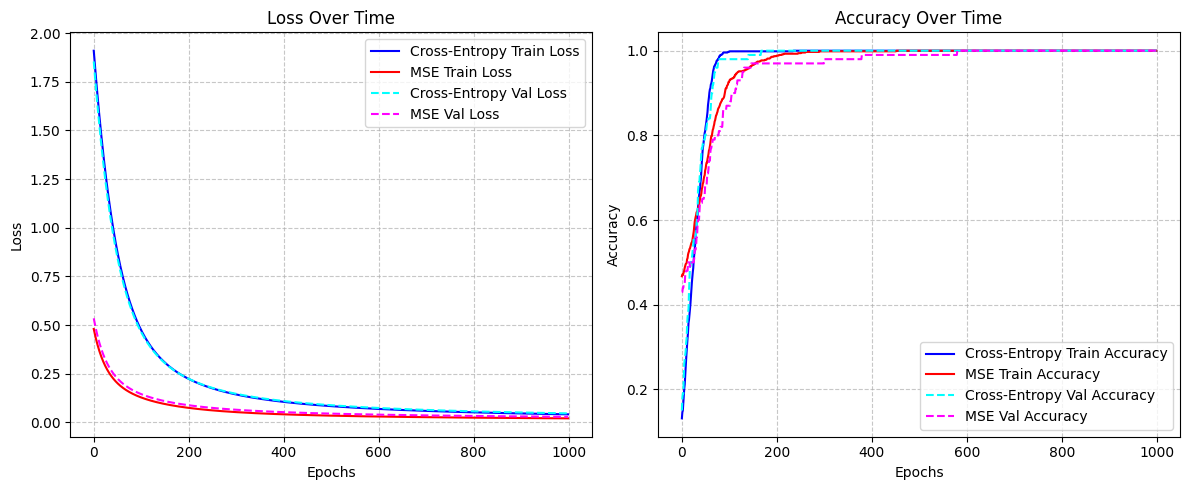

In [12]:
# Plotting training results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ce_losses, label='Cross-Entropy Train Loss', color='blue')
plt.plot(mse_losses, label='MSE Train Loss', color='red')
plt.plot(ce_val_losses, label='Cross-Entropy Val Loss', color='cyan', linestyle='--') # Added CE validation loss
plt.plot(mse_val_losses, label='MSE Val Loss', color='magenta', linestyle='--') # Added MSE validation loss
plt.title('Loss Over Time') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.plot(ce_accuracies, label='Cross-Entropy Train Accuracy', color='blue')
plt.plot(mse_accuracies, label='MSE Train Accuracy', color='red')
plt.plot(ce_val_accuracies, label='Cross-Entropy Val Accuracy', color='cyan', linestyle='--') # Added CE validation accuracy
plt.plot(mse_val_accuracies, label='MSE Val Accuracy', color='magenta', linestyle='--') # Added MSE validation accuracy
plt.title('Accuracy Over Time') # Updated title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [13]:
# Evaluate on test set
def evaluate_model(model):
    model.eval()
    # Move model to device
    model = model.to(device)
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
    return accuracy

ce_test_accuracy = evaluate_model(ce_model)
mse_test_accuracy = evaluate_model(mse_model)

print(f"\nTest Accuracy - Cross-Entropy: {ce_test_accuracy:.4f}")
print(f"Test Accuracy - MSE: {mse_test_accuracy:.4f}")


Test Accuracy - Cross-Entropy: 1.0000
Test Accuracy - MSE: 1.0000


In [14]:
if torch.cuda.is_available():
    ce_model = ce_model.cpu()
    mse_model = mse_model.cpu()

<Figure size 1200x500 with 0 Axes>

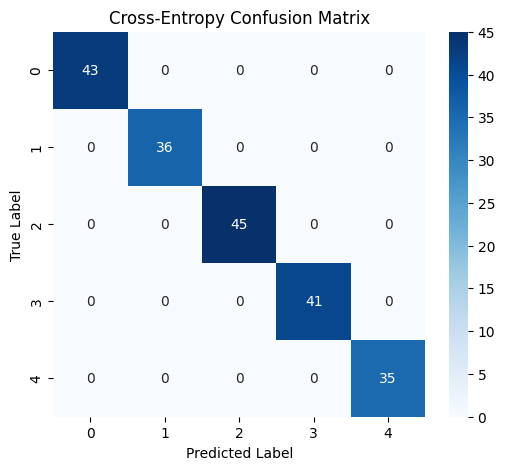

<Figure size 1200x500 with 0 Axes>

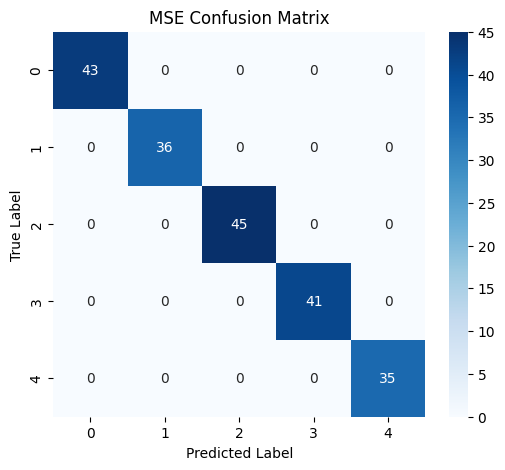

In [18]:
# Confusion matrix visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X, y, title):
    model.eval()
    with torch.no_grad():
        outputs = model(torch.FloatTensor(X))
        _, predicted = torch.max(outputs.data, 1)

    cm = confusion_matrix(y, predicted.numpy())
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# Plot confusion matrices
plt.figure(figsize=(12, 5))
plot_confusion_matrix(ce_model, X_test, y_test, "Cross-Entropy Confusion Matrix")
plt.show()

plt.figure(figsize=(12, 5))
plot_confusion_matrix(mse_model, X_test, y_test, "MSE Confusion Matrix")
plt.show()